# What is the main contributor to cancelled orders in Ecommerce?

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-data/data.csv


In [2]:
# required installations
!pip3 install pandas pymongo numpy seaborn transformers sentence_transformers ipywidgets

## Imports and Data Preprocessing

In [3]:
# imports
import pandas as pd
import sqlite3
from pymongo import MongoClient
import numpy as np
import seaborn as sns
from transformers import pipeline, set_seed, AutoTokenizer, AutoModelForSeq2SeqLM
import time
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
import random
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import torch
from torch.nn import DataParallel
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [4]:
# parsing error due to GBP symbol not recognized by UTF-8, thus using ISO-8859-1
data = pd.read_csv("/kaggle/input/ecommerce-data/data.csv", encoding="ISO-8859-1")

In [5]:
# data visualization
print(data.dtypes)
data.head(5)

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
# data preprocessing begins here
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
# as seen description and CustomerID are the only missing values. Checking if it happens only when both or is conditional
missing_rows = data[data['CustomerID'].isnull() | data['Description'].isnull()]
missing_description = data[data['CustomerID'].notnull() & data['Description'].isnull()]
len(missing_description)

0

In [8]:
# since whenever CustomerID is missing so is the description, I will filter these out completely as they are not helpful
data = data[data['CustomerID'].notnull() & data['Description'].notnull()]
data.isnull().sum().sum()

0

In [9]:
category_txt = """Appliances: Large and small kitchen appliances, vacuums, air conditioners, etc.
Arts, Crafts & Sewing: Supplies for painting, drawing, sculpting, sewing, knitting, etc.
Automotive Parts & Accessories: Car parts, batteries, tools, car care products, etc.
Baby: Diapers, wipes, feeding supplies, baby clothes, furniture, etc. (Gated)
Beauty & Personal Care: Cosmetics, skin/hair care, fragrances, shaving supplies, etc.
Beverages: Coffee, tea, soda, juice, alcoholic drinks, etc. (Gated)
Books: Physical books across all genres, including fiction, non-fiction, textbooks, etc.
Business & Industrial: Office supplies, industrial equipment, cleaning supplies, etc.
Cameras & Photo: Cameras, lenses, tripods, photo accessories, etc.
Cell Phones & Accessories: Smartphones, cases, chargers, headphones, etc.
Clothing, Shoes & Jewelry: Clothing, footwear, jewelry, watches, etc.
Collectibles & Fine Art: Coins, stamps, antiques, artwork, etc. (Gated)
Computers: Laptops, desktops, tablets, monitors, computer components, etc.
Digital Music: MP3 downloads and streaming services (Gated)
Electronics: TVs, audio equipment, video game consoles, etc.
Entertainment Collectibles: Memorabilia from movies, TV shows, video games, etc.
Food: Snacks, pantry staples, condiments, international foods, etc. (Gated)
Furniture: Sofas, beds, tables, chairs, outdoor furniture, etc.
Garden & Outdoor: Plants, seeds, gardening tools, patio furniture, grills, etc.
Grocery & Food: Produce, dairy products, prepared meals, specialty foods, etc. (Gated)
Health & Household: Vitamins, supplements, OTC medications, cleaning supplies, etc.
Home & Kitchen: Cookware, appliances, bakeware, dinnerware, furniture, décor, etc.
Industrial & Scientific: Lab equipment, safety gear, tools, machinery, etc. (Gated)
Jewelry: Fine jewelry, fashion jewelry, watches, etc.
Kindle eBooks: Digital ebooks for Kindle devices and apps
Lawns & Garden: Plants, seeds, fertilizers, tools, outdoor furniture, etc.
Luggage & Travel Gear: Suitcases, backpacks, duffel bags, travel accessories, etc.
Movies & TV: DVDs, Blu-rays, digital downloads, streaming services (Gated)
Musical Instruments: Guitars, pianos, drums, sheet music, etc.
Office Products: Paper, pens, notebooks, printers, ink cartridges, etc.
Patio, Lawn & Garden: Plants, seeds, gardening tools, outdoor furniture, grills, etc.
Pet Supplies: Food, treats, toys, beds, leashes, etc.
Software: Computer software, video games, etc. (Gated)
Sports & Outdoors: Sporting equipment, apparel, footwear, camping gear, etc.
Tools & Hardware: Power tools, hand tools, building supplies, etc.
Toys & Games: Classic toys, educational toys, electronic toys, games, puzzles, etc.
Video Games: Video game consoles, games, accessories, etc. (Gated)"""

categories = []
for l in category_txt.split('\n'):
    categories.append(l.split(':')[0])
categories

['Appliances',
 'Arts, Crafts & Sewing',
 'Automotive Parts & Accessories',
 'Baby',
 'Beauty & Personal Care',
 'Beverages',
 'Books',
 'Business & Industrial',
 'Cameras & Photo',
 'Cell Phones & Accessories',
 'Clothing, Shoes & Jewelry',
 'Collectibles & Fine Art',
 'Computers',
 'Digital Music',
 'Electronics',
 'Entertainment Collectibles',
 'Food',
 'Furniture',
 'Garden & Outdoor',
 'Grocery & Food',
 'Health & Household',
 'Home & Kitchen',
 'Industrial & Scientific',
 'Jewelry',
 'Kindle eBooks',
 'Lawns & Garden',
 'Luggage & Travel Gear',
 'Movies & TV',
 'Musical Instruments',
 'Office Products',
 'Patio, Lawn & Garden',
 'Pet Supplies',
 'Software',
 'Sports & Outdoors',
 'Tools & Hardware',
 'Toys & Games',
 'Video Games']

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = DataParallel(SentenceTransformer("all-MiniLM-L6-v2").to(device))
category_embeddings = model.module.encode(categories, convert_to_tensor=True, device=device)
batch_size = 64
def batch_gen_categories(descriptions):
    s = time.time()
    description_embeddings = model.module.encode(descriptions, batch_size=batch_size, convert_to_tensor=True, device=device)
    scores = util.cos_sim(description_embeddings, category_embeddings)
    results = []
    for score in scores:
        top_scores = score.topk(random.randint(3, 5))
        top_categories = [categories[idx] for idx in top_scores.indices.tolist()]
        results.append(top_categories)
    print(f"Time to create categories: {time.time() - s: 0.2f}s (this initially took 4 hours)")
    return results

data['Categories'] = batch_gen_categories(data['Description'].tolist())

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6357 [00:00<?, ?it/s]

Time to create categories:  67.28s (this initially took 4 hours)


## Inspecting the Data with SQL 

In [11]:
# inspecting data a bit closer
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Categories
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,"[Jewelry, Collectibles & Fine Art, Cell Phones..."
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,"[Jewelry, Entertainment Collectibles, Electron..."
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,"[Jewelry, Clothing, Shoes & Jewelry, Collectib..."
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,"[Beverages, Collectibles & Fine Art, Jewelry, ..."
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,"[Jewelry, Clothing, Shoes & Jewelry, Beauty & ..."
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France,"[Furniture, Entertainment Collectibles, Pet Su..."
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France,"[Arts, Crafts & Sewing, Furniture, Clothing, S..."
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France,"[Arts, Crafts & Sewing, Toys & Games, Jewelry]"
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France,"[Entertainment Collectibles, Toys & Games, Pet..."


In [12]:
# creating SQL connection
#conn.close()
conn = sqlite3.connect('ecommerce.db')
cursor = conn.cursor()

In [13]:
# filter out the categories as they are difficult to use in SQL (not atomic)
sql_data = data.drop(columns=['Categories'])
# get date into consistent format, will need later
sql_data['InvoiceDate'] = pd.to_datetime(sql_data['InvoiceDate'], format='%m/%d/%Y %H:%M').dt.strftime('%Y-%m-%d %H:%M:%S')
sql_data.to_sql(name='Ecommerce', con=conn, if_exists="replace", index=False)

406829

In [14]:
# use this to better visualize output and sleep to space out db update and queries.
time.sleep(5) 
def pretty_output(res):
    cols = [col[0] for col in cursor.description]
    print(", ".join(cols))
    for row in res:
        print(row)

In [15]:
# check connection
results = cursor.execute("""
SELECT *
FROM Ecommerce
ORDER BY InvoiceDate
LIMIT 5
""").fetchall()

pretty_output(results)

InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country
('536365', '85123A', 'WHITE HANGING HEART T-LIGHT HOLDER', 6, '2010-12-01 08:26:00', 2.55, 17850.0, 'United Kingdom')
('536365', '71053', 'WHITE METAL LANTERN', 6, '2010-12-01 08:26:00', 3.39, 17850.0, 'United Kingdom')
('536365', '84406B', 'CREAM CUPID HEARTS COAT HANGER', 8, '2010-12-01 08:26:00', 2.75, 17850.0, 'United Kingdom')
('536365', '84029G', 'KNITTED UNION FLAG HOT WATER BOTTLE', 6, '2010-12-01 08:26:00', 3.39, 17850.0, 'United Kingdom')
('536365', '84029E', 'RED WOOLLY HOTTIE WHITE HEART.', 6, '2010-12-01 08:26:00', 3.39, 17850.0, 'United Kingdom')


In [16]:
# get the number of unique invoices
num_unique_invoices = cursor.execute("""
SELECT COUNT(DISTINCT(InvoiceNo)) AS numInvoices
FROM Ecommerce
""").fetchall()
pretty_output(num_unique_invoices)

numInvoices
(22190,)


In [17]:
# get the unique invoices (limiting so print isnt as bad)
unique_invoices = cursor.execute("""
SELECT DISTINCT(InvoiceNo) AS Invoices
FROM Ecommerce
LIMIT 20
""").fetchall()

pretty_output(unique_invoices)

Invoices
('536365',)
('536366',)
('536367',)
('536368',)
('536369',)
('536370',)
('536371',)
('536372',)
('536373',)
('536374',)
('536375',)
('536376',)
('536377',)
('536378',)
('536380',)
('536381',)
('C536379',)
('536382',)
('C536383',)
('536384',)


In [18]:
# All the invoices that have C in the front are cancelled invoices, get all the unique invoices that do not start with C
valid_invoices = cursor.execute("""
SELECT DISTINCT(InvoiceNo) AS validInvoices
FROM Ecommerce
WHERE InvoiceNo NOT LIKE 'C%'
LIMIT 20
""").fetchall()

pretty_output(valid_invoices)

validInvoices
('536365',)
('536366',)
('536367',)
('536368',)
('536369',)
('536370',)
('536371',)
('536372',)
('536373',)
('536374',)
('536375',)
('536376',)
('536377',)
('536378',)
('536380',)
('536381',)
('536382',)
('536384',)
('536385',)
('536386',)


## Comparing Reasons for Invoice Cancellations with SQL

In [19]:
# Figure out the ratio of cancelled invoices to total invoices
ratioCancelledInvoices = cursor.execute("""
SELECT 
    COUNT(*) AS TotalInvoices, 
    SUM(CASE WHEN InvoiceNo LIKE 'C%' THEN 1 ELSE 0 END) AS CountStartingWithC, 
    CAST(SUM(CASE WHEN InvoiceNo LIKE 'C%' THEN 1 ELSE 0 END) AS FLOAT) / COUNT(*) AS Proportion
FROM (
    SELECT DISTINCT InvoiceNo
    FROM Ecommerce
) DistinctInvoices
""").fetchall()

pretty_output(ratioCancelledInvoices)

TotalInvoices, CountStartingWithC, Proportion
(22190, 3654, 0.16466876971608832)


In [20]:
# lets see if perhaps the date has a role in this, maybe its a monthly thing

# first check the type of InvoiceDate
print(list(map(lambda x : x[1:3], cursor.execute("PRAGMA table_info(Ecommerce)").fetchall())))

# since InvoiceDate is a text type we will want to change that, with some googling theres a SQL substr operation
cursor.execute("ALTER TABLE Ecommerce ADD COLUMN Day TEXT")
cursor.execute("ALTER TABLE Ecommerce ADD COLUMN Month TEXT")
cursor.execute("ALTER TABLE Ecommerce ADD COLUMN Year TEXT")
cursor.execute("ALTER TABLE Ecommerce ADD COLUMN Time TEXT")
tmp = cursor.execute("""
UPDATE Ecommerce
SET 
    Day = substr(InvoiceDate, 9, 2),
    Month = substr(InvoiceDate, 6, 2),
    Year = substr(InvoiceDate, 1, 4),
    Time = substr(InvoiceDate, 12, 8)
""")

pretty_output(cursor.execute("SELECT * FROM Ecommerce LIMIT 5").fetchall())

[('InvoiceNo', 'TEXT'), ('StockCode', 'TEXT'), ('Description', 'TEXT'), ('Quantity', 'INTEGER'), ('InvoiceDate', 'TEXT'), ('UnitPrice', 'REAL'), ('CustomerID', 'REAL'), ('Country', 'TEXT')]
InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, Day, Month, Year, Time
('536365', '85123A', 'WHITE HANGING HEART T-LIGHT HOLDER', 6, '2010-12-01 08:26:00', 2.55, 17850.0, 'United Kingdom', '01', '12', '2010', '08:26:00')
('536365', '71053', 'WHITE METAL LANTERN', 6, '2010-12-01 08:26:00', 3.39, 17850.0, 'United Kingdom', '01', '12', '2010', '08:26:00')
('536365', '84406B', 'CREAM CUPID HEARTS COAT HANGER', 8, '2010-12-01 08:26:00', 2.75, 17850.0, 'United Kingdom', '01', '12', '2010', '08:26:00')
('536365', '84029G', 'KNITTED UNION FLAG HOT WATER BOTTLE', 6, '2010-12-01 08:26:00', 3.39, 17850.0, 'United Kingdom', '01', '12', '2010', '08:26:00')
('536365', '84029E', 'RED WOOLLY HOTTIE WHITE HEART.', 6, '2010-12-01 08:26:00', 3.39, 17850.0, 'United Kingdom', '0

In [21]:
# use this to graph day, month, year
def barplot(pd_frame: pd.DataFrame, x: str, y: str, title: str):
    plt.figure(figsize=(12,6))
    sns.barplot(x=x, y=y, data=pd_frame, palette='viridis')
    plt.title(title)
    plt.tight_layout()
    if(pd_frame[x].size > 200):
        plt.xticks(ticks=range(0, pd_frame[x].size, 50), rotation=45)
    print(pd_frame[x].dtype)
    if(pd_frame[x].dtype == 'object'):
        plt.xticks(rotation=45, ha='right', va='top')
    plt.show()

object


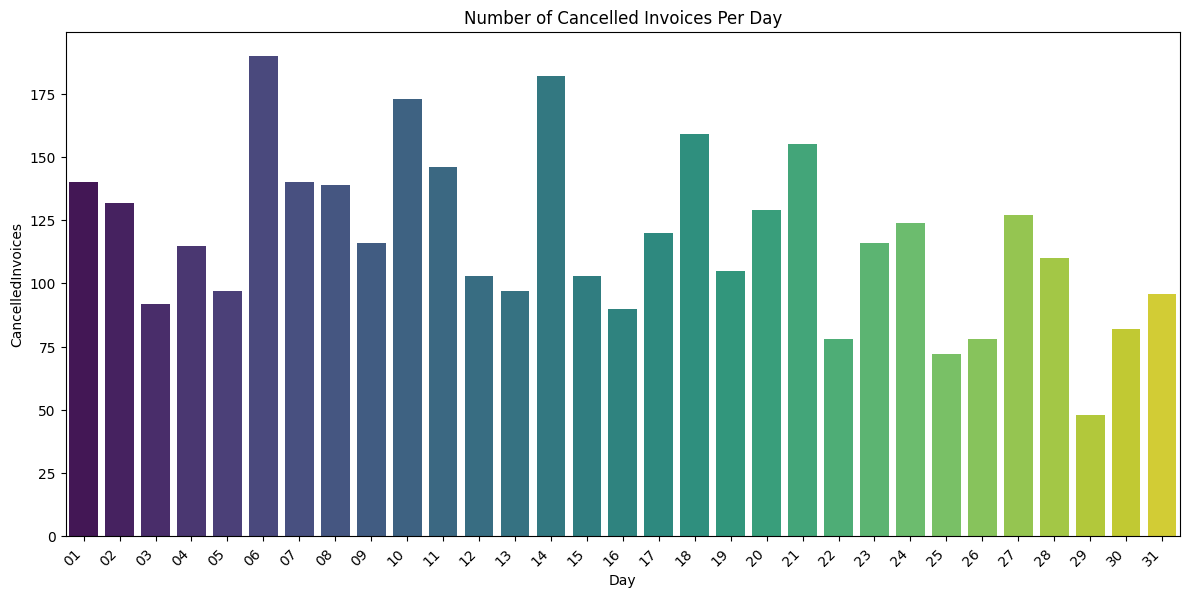

object


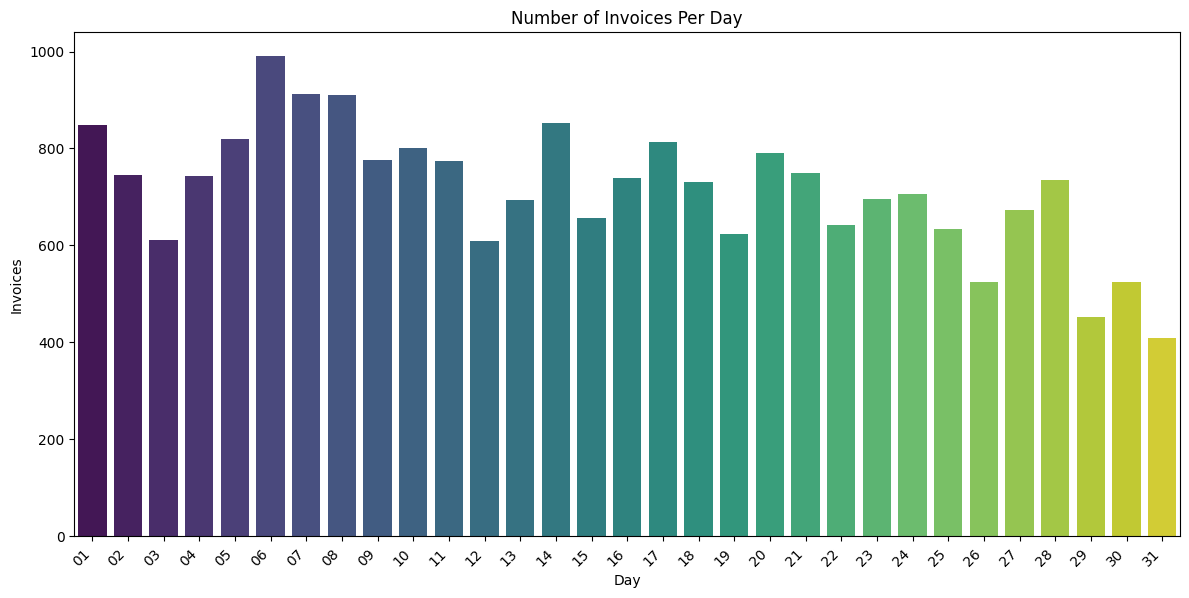

In [22]:
# now lets see if month, day or year have a role in this (only brief correlation check)
cancellations_day = cursor.execute("""
SELECT Day, COUNT(DISTINCT InvoiceNo) AS CancelledInvoices
FROM Ecommerce
WHERE InvoiceNo LIKE 'C%'
GROUP BY Day
ORDER BY Day
""").fetchall()

# creating bar graph with seaborn to visualize this
cancellations_day_df = pd.DataFrame(cancellations_day, columns=['Day', 'CancelledInvoices'])
barplot(cancellations_day_df, 'Day', 'CancelledInvoices', 'Number of Cancelled Invoices Per Day')

invoices_day = cursor.execute("""
SELECT Day, COUNT(DISTINCT InvoiceNo) AS Invoices
FROM Ecommerce
GROUP BY Day
ORDER BY Day
""").fetchall()

# creating bar graph with seaborn to visualize this
invoices_day_df = pd.DataFrame(invoices_day, columns=['Day', 'Invoices'])
barplot(invoices_day_df, 'Day', 'Invoices', 'Number of Invoices Per Day')

object


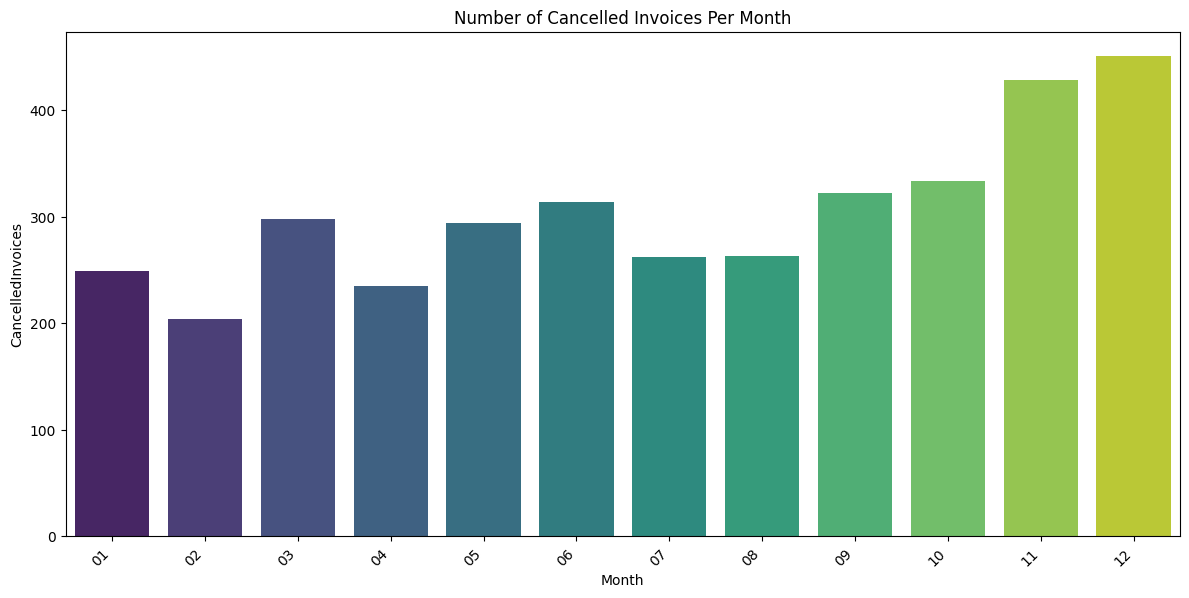

object


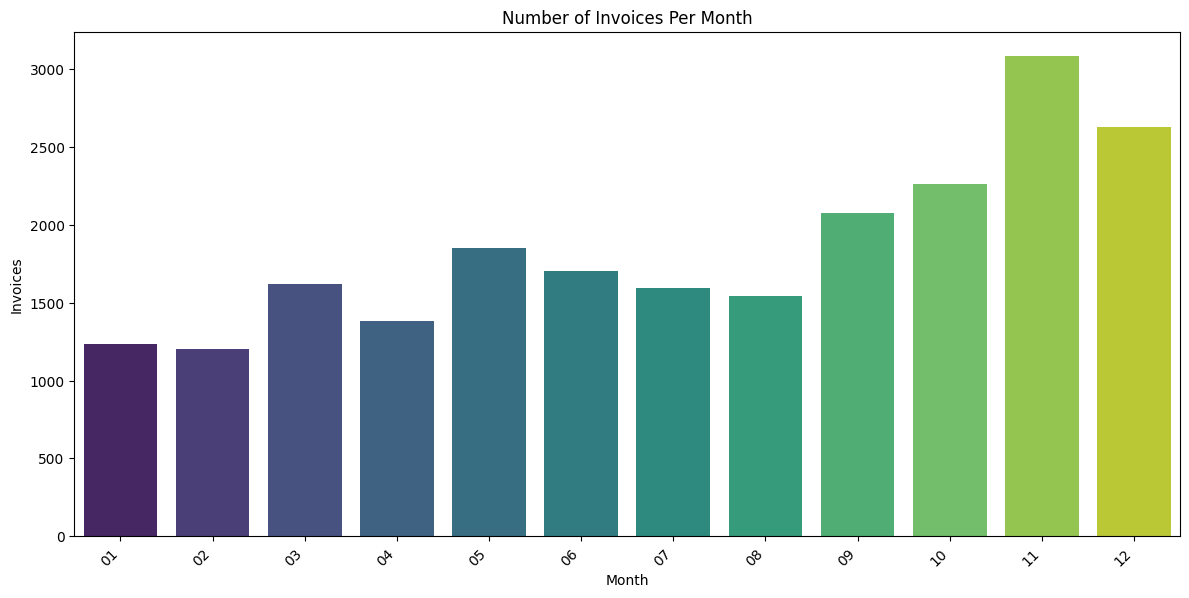

In [23]:
cancellations_month = cursor.execute("""
SELECT Month, COUNT(DISTINCT InvoiceNo) AS CancelledInvoices
FROM Ecommerce
WHERE InvoiceNo LIKE 'C%'
GROUP BY Month
ORDER BY Month
""").fetchall()

cancellations_month_df = pd.DataFrame(cancellations_month, columns=['Month', 'CancelledInvoices'])
barplot(cancellations_month_df, 'Month', 'CancelledInvoices', 'Number of Cancelled Invoices Per Month')

invoices_month = cursor.execute("""
SELECT Month, COUNT(DISTINCT InvoiceNo) AS Invoices
FROM Ecommerce
GROUP BY Month
ORDER BY Month
""").fetchall()

invoices_month_df = pd.DataFrame(invoices_month, columns=['Month', 'Invoices'])
barplot(invoices_month_df, 'Month', 'Invoices', 'Number of Invoices Per Month')

object


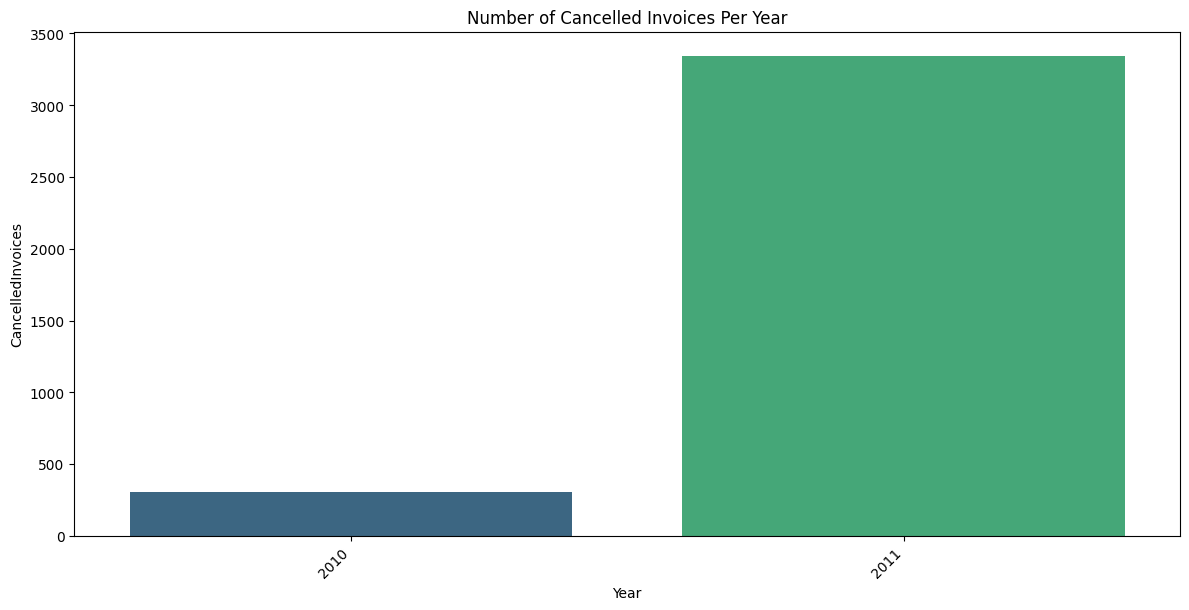

object


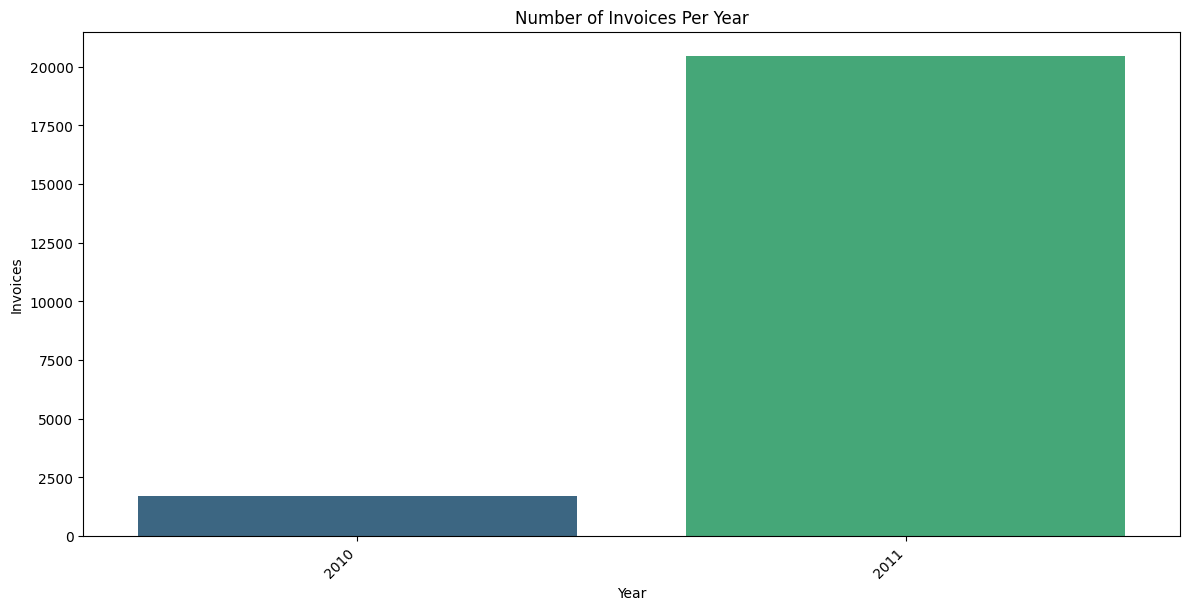

In [24]:
cancellations_year = cursor.execute("""
SELECT Year, COUNT(DISTINCT InvoiceNo) AS CancelledInvoices
FROM Ecommerce
WHERE InvoiceNo LIKE 'C%'
GROUP BY Year
ORDER BY Year
""").fetchall()

cancellations_year_df = pd.DataFrame(cancellations_year, columns=['Year', 'CancelledInvoices'])
barplot(cancellations_year_df, 'Year', 'CancelledInvoices', 'Number of Cancelled Invoices Per Year')

invoices_year = cursor.execute("""
SELECT Year, COUNT(DISTINCT InvoiceNo) AS Invoices
FROM Ecommerce
GROUP BY Year
ORDER BY Year
""").fetchall()

invoices_year_df = pd.DataFrame(invoices_year, columns=['Year', 'Invoices'])
barplot(invoices_year_df, 'Year', 'Invoices', 'Number of Invoices Per Year')

object


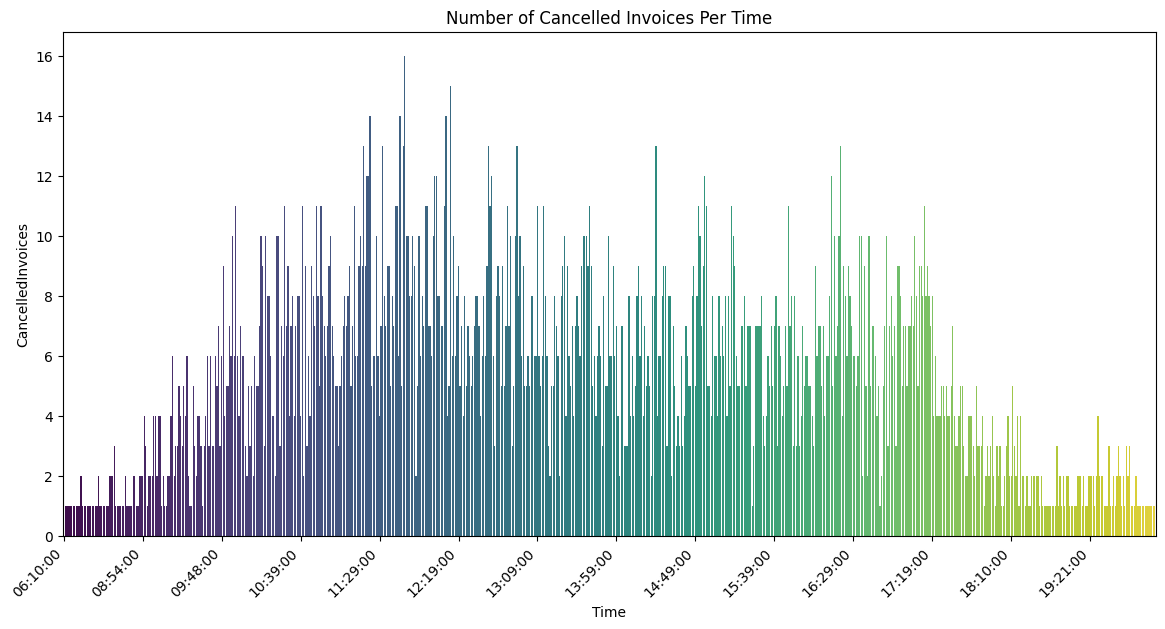

object


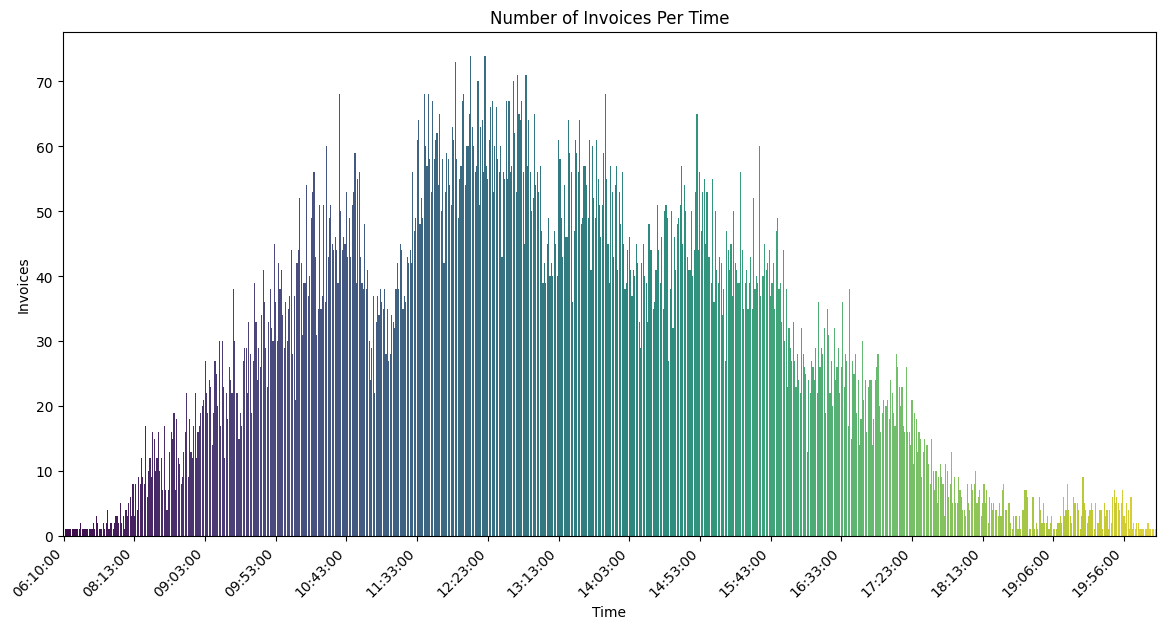

In [25]:
cancellations_time = cursor.execute("""
SELECT Time, COUNT(DISTINCT InvoiceNo) AS CancelledInvoices
FROM Ecommerce
WHERE InvoiceNo LIKE 'C%'
GROUP BY Time
ORDER BY Time
""").fetchall()

cancellations_time_df = pd.DataFrame(cancellations_time, columns=['Time', 'CancelledInvoices'])
barplot(cancellations_time_df, 'Time', 'CancelledInvoices', 'Number of Cancelled Invoices Per Time')


invoices_time = cursor.execute("""
SELECT Time, COUNT(DISTINCT InvoiceNo) AS Invoices
FROM Ecommerce
GROUP BY Time
ORDER BY Time
""").fetchall()

invoices_time_df = pd.DataFrame(invoices_time, columns=['Time', 'Invoices'])
barplot(invoices_time_df, 'Time', 'Invoices', 'Number of Invoices Per Time')

In [26]:
# this generally looks a bit more normal (literally and statistically), but thats CLT.
# lets prove if they are different or not with the Kolmogorov-Smirnov test
cancellations_time_df['Normalized'] = (cancellations_time_df['CancelledInvoices'] - cancellations_time_df['CancelledInvoices'].mean()) / cancellations_time_df['CancelledInvoices'].std()
invoices_time_df['Normalized'] = (invoices_time_df['Invoices'] - invoices_time_df['Invoices'].mean()) / invoices_time_df['Invoices'].std()
invoices_time_df['Time'] = pd.to_datetime(invoices_time_df['Time'], format='%H:%M:%S')
cancellations_time_df['Time'] = pd.to_datetime(cancellations_time_df['Time'], format='%H:%M:%S')
invoices_time_df = invoices_time_df.sort_values(by='Time').reset_index(drop=True)
cancellations_time_df = cancellations_time_df.sort_values(by='Time').reset_index(drop=True)
stat, p_val = ks_2samp(cancellations_time_df['Normalized'], invoices_time_df['Normalized'])
if p_val < 0.05:
    print(f"""Since the two distributions are quite dissimilar, its fair to say that its likely that purchase activity
    does NOT play a role in the number of cancellations. This would indicate another factor does. P-value: {p_val}""")
else:
    print(f"""Since the two distributions are quite dissimilar, its fair to say that its likely that purchase activity
    does play a role in the number of cancellations. {p_val}""")

Since the two distributions are quite dissimilar, its fair to say that its likely that purchase activity
    does NOT play a role in the number of cancellations. This would indicate another factor does. P-value: 2.9391863617941254e-07


In [27]:
# lets check if we can find some trends with Day, Month or Year
# first year because visually I would have to guess this is because of an inbalance in the dataset
# to check use SQL
invoices_per_year = cursor.execute("""
SELECT Year, COUNT(DISTINCT InvoiceNo) AS InvoicesFor2011
FROM Ecommerce
GROUP BY Year
ORDER BY Year
""").fetchall()
invoices_year_df = pd.DataFrame(invoices_per_year, columns=['Year', 'Invoices'])
invoices_year_df
# compare proportion of 2010 for both invoices and cancelled invoices
invoices_2011 = int(invoices_year_df[invoices_year_df['Year'] == '2011']['Invoices'].item())
invoices_2010 = int(invoices_year_df[invoices_year_df['Year'] == '2010']['Invoices'].item())
prop_invoices = invoices_2010 / (invoices_2010 + invoices_2011)
cancellations_2011 = int(cancellations_year_df[cancellations_year_df['Year'] == '2011']['CancelledInvoices'].item())
cancellations_2010 = int(cancellations_year_df[cancellations_year_df['Year'] == '2010']['CancelledInvoices'].item())
prop_cancellations = cancellations_2010 / (cancellations_2010 + cancellations_2011)
prop_invoices, prop_cancellations

(0.07697160883280757, 0.0842911877394636)

In [28]:
# pretty similar so not year, check for month and day
# using spearman as data seems relatively monotonic
spear_corr_month = cancellations_month_df['CancelledInvoices'].corr(invoices_month_df['Invoices'], method='spearman')
spear_corr_day = cancellations_day_df['CancelledInvoices'].corr(invoices_day_df['Invoices'], method='spearman')

print("Monthly Corr: ", spear_corr_month)
print("Daily Corr: ", spear_corr_day)

Monthly Corr:  0.9580419580419581
Daily Corr:  0.7644745427561901


object


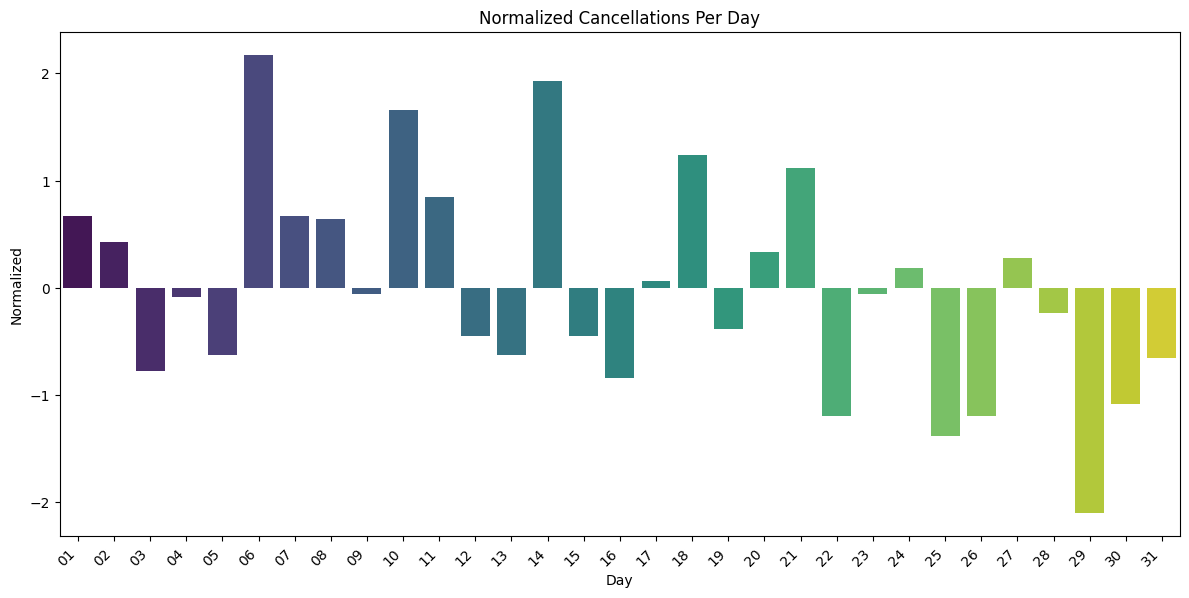

object


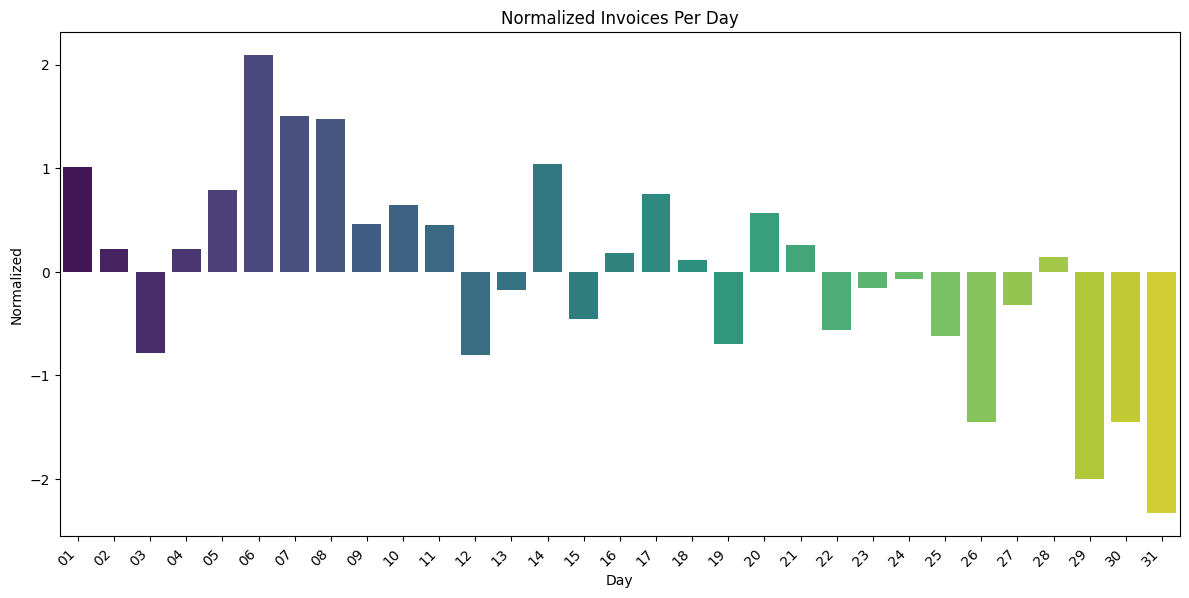

In [29]:
# With the spearman correlations we can see there is a very strong correlation between cancellations and total invoices per month, and just a strong correlation for days.
# This warrants a closer look at days, lets normalize them and see if that helps
cancellations_day_df['Normalized'] = (cancellations_day_df['CancelledInvoices'] - cancellations_day_df['CancelledInvoices'].mean()) / cancellations_day_df['CancelledInvoices'].std()
invoices_day_df['Normalized'] = (invoices_day_df['Invoices'] - invoices_day_df['Invoices'].mean()) / invoices_day_df['Invoices'].std()

# graph with normalized on y and day on x
barplot(cancellations_day_df, 'Day','Normalized', 'Normalized Cancellations Per Day')
barplot(invoices_day_df, 'Day','Normalized', 'Normalized Invoices Per Day')

### Overall Conclusion:
I believe that any form of date, whether it be day month or time, is not a contributing factor to the number of cancelled orders. This more than likely is due to the number of orders during a specific time frame which then logically follows that there are more cancellations over the same time frame. With mongoDB I will see if there is any correlation with the number of cancellations based on category or customerID.

## MongoDB Analyzation:

In [30]:
# imports
from kaggle_secrets import UserSecretsClient
import uuid

In [31]:
user_secrets = UserSecretsClient()
clientSrvLink = user_secrets.get_secret("MONGO_LINK")

# create connection using secret api link (NOTE: for others please keep this secret step do not leave a username and password to a paid service to others online)
client = MongoClient(f'{clientSrvLink}')
db = client['ecommerce']
invoices = db['Invoices']

In [32]:
# prepare data for insertion in mongoDB
data['_id'] = [str(uuid.uuid4()) for _ in range(len(data))]
records = data.to_dict(orient='records')
records[:3]

[{'InvoiceNo': '536365',
  'StockCode': '85123A',
  'Description': 'WHITE HANGING HEART T-LIGHT HOLDER',
  'Quantity': 6,
  'InvoiceDate': '12/1/2010 8:26',
  'UnitPrice': 2.55,
  'CustomerID': 17850.0,
  'Country': 'United Kingdom',
  'Categories': ['Jewelry',
   'Collectibles & Fine Art',
   'Cell Phones & Accessories',
   'Automotive Parts & Accessories'],
  '_id': '3346c0db-adc7-4e28-9c97-63493180c6a1'},
 {'InvoiceNo': '536365',
  'StockCode': '71053',
  'Description': 'WHITE METAL LANTERN',
  'Quantity': 6,
  'InvoiceDate': '12/1/2010 8:26',
  'UnitPrice': 3.39,
  'CustomerID': 17850.0,
  'Country': 'United Kingdom',
  'Categories': ['Jewelry',
   'Entertainment Collectibles',
   'Electronics',
   'Books'],
  '_id': 'fe5e237e-66a7-4ae7-946f-e49a4db5765e'},
 {'InvoiceNo': '536365',
  'StockCode': '84406B',
  'Description': 'CREAM CUPID HEARTS COAT HANGER',
  'Quantity': 8,
  'InvoiceDate': '12/1/2010 8:26',
  'UnitPrice': 2.75,
  'CustomerID': 17850.0,
  'Country': 'United Kingdom'

In [33]:
# insert into DB
try:
    invoices.delete_many({})
    invoices.insert_many(records, ordered=False)
    print("Data inserted successfully!")
except Exception as e:
    print(f"Error during insertion: {e}")

Data inserted successfully!


In [34]:
# get first 5 queries
res = invoices.find().limit(5)
list(res)

[{'_id': '3346c0db-adc7-4e28-9c97-63493180c6a1',
  'InvoiceNo': '536365',
  'StockCode': '85123A',
  'Description': 'WHITE HANGING HEART T-LIGHT HOLDER',
  'Quantity': 6,
  'InvoiceDate': '12/1/2010 8:26',
  'UnitPrice': 2.55,
  'CustomerID': 17850.0,
  'Country': 'United Kingdom',
  'Categories': ['Jewelry',
   'Collectibles & Fine Art',
   'Cell Phones & Accessories',
   'Automotive Parts & Accessories']},
 {'_id': 'fe5e237e-66a7-4ae7-946f-e49a4db5765e',
  'InvoiceNo': '536365',
  'StockCode': '71053',
  'Description': 'WHITE METAL LANTERN',
  'Quantity': 6,
  'InvoiceDate': '12/1/2010 8:26',
  'UnitPrice': 3.39,
  'CustomerID': 17850.0,
  'Country': 'United Kingdom',
  'Categories': ['Jewelry',
   'Entertainment Collectibles',
   'Electronics',
   'Books']},
 {'_id': '49a26800-eccc-4aec-a63b-75fce051a39a',
  'InvoiceNo': '536365',
  'StockCode': '84406B',
  'Description': 'CREAM CUPID HEARTS COAT HANGER',
  'Quantity': 8,
  'InvoiceDate': '12/1/2010 8:26',
  'UnitPrice': 2.75,
  'Cu

In [35]:
# get all the documents who's invoiceNo starts with C
cancellations = invoices.find({"InvoiceNo" : {"$regex": "^C"}})
len(list(cancellations))

8905

In [36]:
# get the total number of invoices
invoice_docs = invoices.count_documents({})
invoice_docs

406829

In [37]:
# get the total profit of invoices (note: this includes the negative values from cancellations, but with total loss from cancellations we can get total profit if no cancellations happened)
pipeline = [
    {
      '$project' : {
          'total' : {'$multiply' : ["$Quantity", "$UnitPrice"]}
      }  
    },
    {
        '$group' : {
            '_id': None,
            'total_sum' : {'$sum' : '$total'}
        }
    }   
]

total_revenue = list(invoices.aggregate(pipeline))
total_revenue

[{'_id': None, 'total_sum': 8300065.814}]

In [38]:
# get total loss due to cancellations
pipeline = [
    {
        "$match" : {
            "InvoiceNo" : {"$regex" : "^C"}
        }
    },
    {
        "$project" : {
            "total" : {"$multiply" : ["$Quantity", "$UnitPrice"]}
        }
    },
    {
        "$group" : {
            "_id" : None,
            "total_sum" : {"$sum" : "$total"}
        }
    }
]
total_loss = list(invoices.aggregate(pipeline))
total_loss

[{'_id': None, 'total_sum': -611342.09}]

In [39]:
# percent income lost due to cancellations
revenue = total_revenue[0]['total_sum']
loss = total_loss[0]['total_sum']
no_cancellation_revenue = revenue - loss #subtract in order to add loss since loss is a negative number
proportion = abs(loss) / no_cancellation_revenue
print(f"{proportion * 100:.2f}% lost to cancellations.")

6.86% lost to cancellations.


object


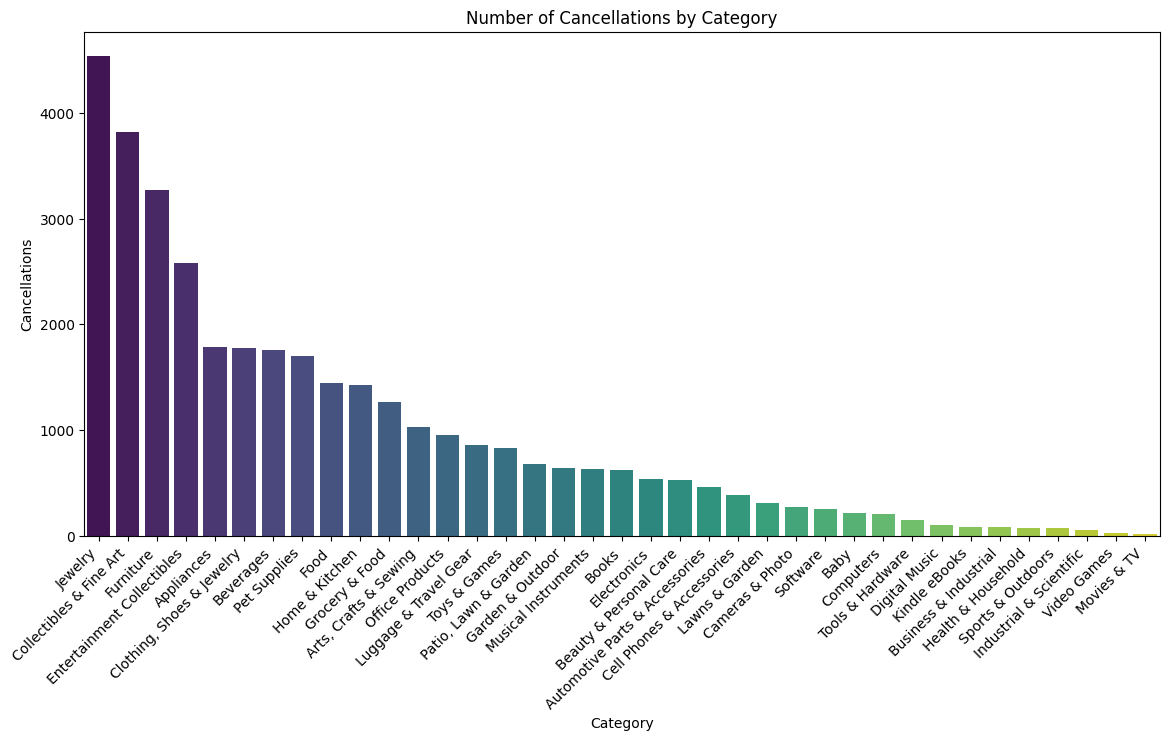

In [40]:
# get total cancellations by Category
pipeline = [
    {
        "$match" : {
            "InvoiceNo" : {"$regex" : "^C"}
        }
    },
    {
        "$unwind" : "$Categories"
    },
    {
        "$group" : {
            "_id" : "$Categories",
            "NumberCancellations" : {
                "$sum" : 1
            }
        }
    },
    {
        "$sort" : {"NumberCancellations" : -1}
    }
]

categorical_cancellations = list(invoices.aggregate(pipeline))
categories = {"Category" : [] , "Cancellations" : []}
for document in categorical_cancellations:
    #print(f"Category: {document['_id']}, and Count: {document['NumberCancellations']}")
    categories.get("Category").append(document['_id'])
    categories.get("Cancellations").append(document['NumberCancellations'])
categories = pd.DataFrame(data=categories)
barplot(categories, "Category", "Cancellations", "Number of Cancellations by Category")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


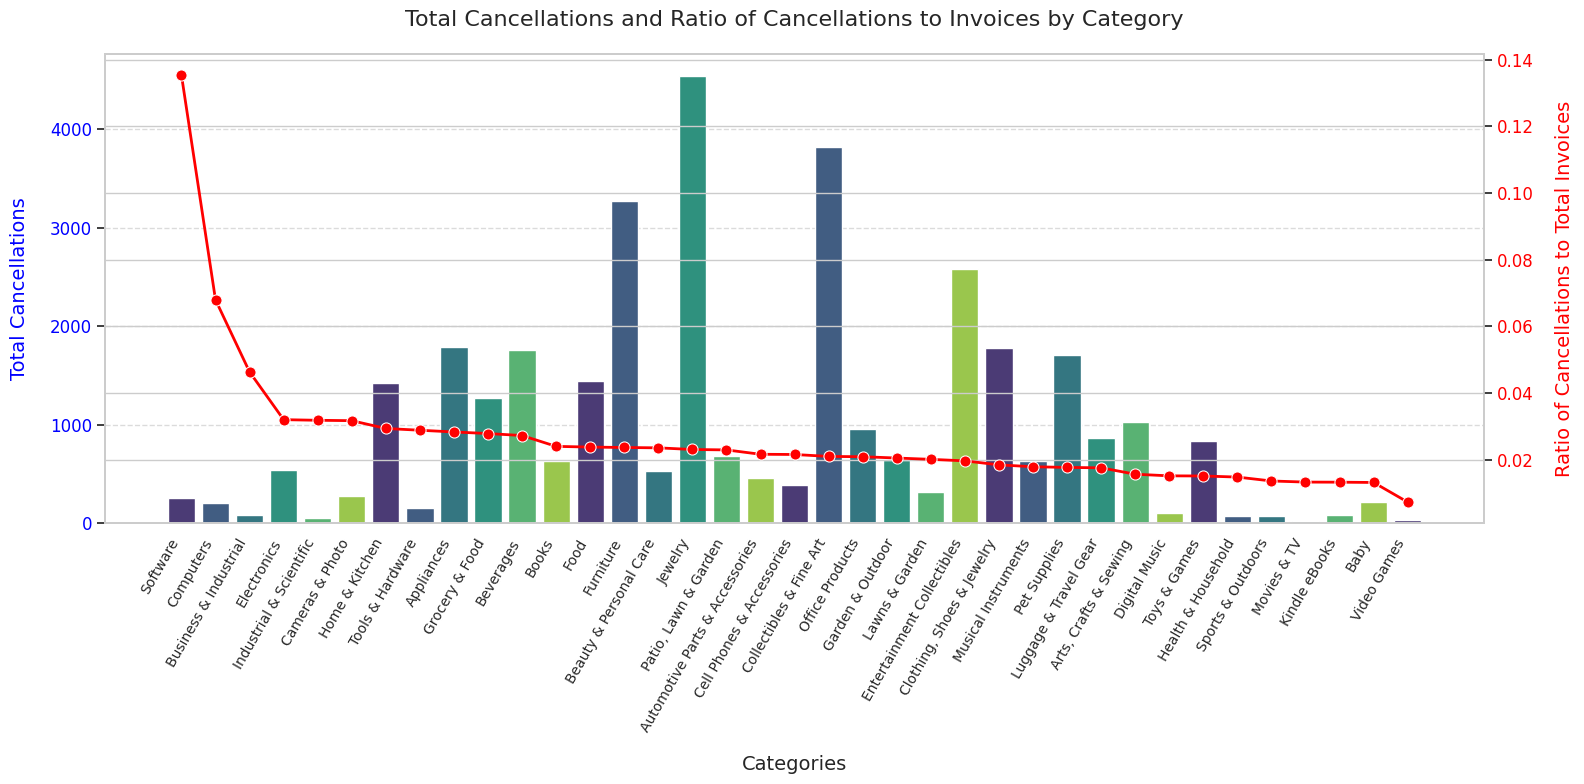

In [41]:
# getting ratios to see relative cancellation counts (doing it purely in mongo but is definitely easier to do by just getting totals now and dividing with pandas.)
pipeline = [
    {
        "$unwind" : "$Categories"
    },
    {
        "$group" : {
            "_id" : "$Categories",
            "total_invoices" : {"$sum" : 1},
            "total_cancellations" : {
                "$sum" : {
                    "$cond" : [
                        {
                            "$regexMatch" : {
                                "input" : "$InvoiceNo", "regex" : "^C"
                            }
                        },
                        1,
                        0
                    ]
                }
            }
        }
    },
    {
        "$addFields" : {
            "ratio" : {
                "$cond" : [
                    {"$eq" : ["$total_invoices", 0]},
                    0,
                    {"$divide" : ["$total_cancellations", "$total_invoices"]}
                ]
            }
        }
    },
    {
        "$sort" : {
            "ratio" : -1
        }
    }
]

canc_ratio_category = list(invoices.aggregate(pipeline))

# graphing
graph_data = {
    'Category' : [doc['_id'] for doc in canc_ratio_category],
    'Total Cancellations' : [doc['total_cancellations'] for doc in canc_ratio_category],
    'Cancellation Ratio' : [doc['ratio'] for doc in canc_ratio_category]
}

graph_data = pd.DataFrame(data=graph_data)

sns.set(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(16,8))
palette = sns.color_palette("viridis")
sns.barplot(x="Category", y="Total Cancellations", data = graph_data, palette=palette, ax=ax1)
ax1.set_xlabel("Categories", fontsize=14, labelpad=15)
ax1.set_ylabel("Total Cancellations", color="blue", fontsize=14, labelpad=15)
ax1.tick_params(axis="y", labelcolor="blue", labelsize=12)
ax1.tick_params(axis="x", labelsize=10, grid_color="gray")
ax1.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=60, ha="right", fontsize=10)

ax2 = ax1.twinx()
sns.lineplot(x="Category", y="Cancellation Ratio", data=graph_data, color="red", marker="o", linewidth=2, markersize=8, ax=ax2)
ax2.set_ylabel("Ratio of Cancellations to Total Invoices", color="red", fontsize=14, labelpad=15)
ax2.tick_params(axis="y", labelcolor="red", labelsize=12)

plt.title("Total Cancellations and Ratio of Cancellations to Invoices by Category", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

object


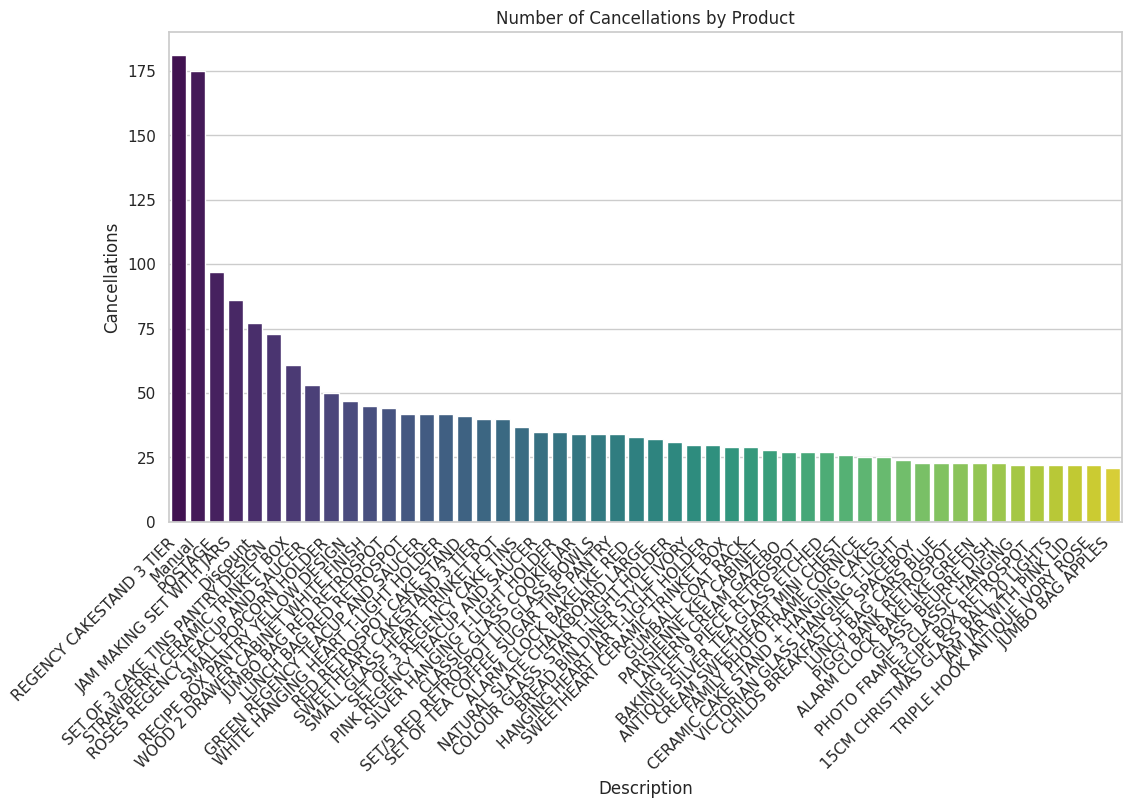

In [42]:
# seems that categories do tend to make a difference on the number of cancellations, lets see if software, computers and business & industrial is due to one specific product being cancelled too often
pipeline = [
    {
        "$match" : {"InvoiceNo" : {"$regex" : "^C"}}
    },
    {
        "$group" : {
            "_id" : "$StockCode",
            "Cancellations" : {"$sum" : 1},
            "description" : {"$first" : "$Description"},
            "categories" : {"$addToSet" : "$Categories"}
        }
    },
    {
        "$sort" : {"Cancellations": -1}
    }
]

cancelled_items = list(invoices.aggregate(pipeline))
plot_data = {
    'Description' : [doc['description'] for doc in cancelled_items],
    'Cancellations' : [doc['Cancellations'] for doc in cancelled_items]
}

plot_data = pd.DataFrame(plot_data)

barplot(plot_data[:50], 'Description', 'Cancellations', 'Number of Cancellations by Product')

Index(['Description', 'Cancellation Rate', 'Total Cancellations'], dtype='object')


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


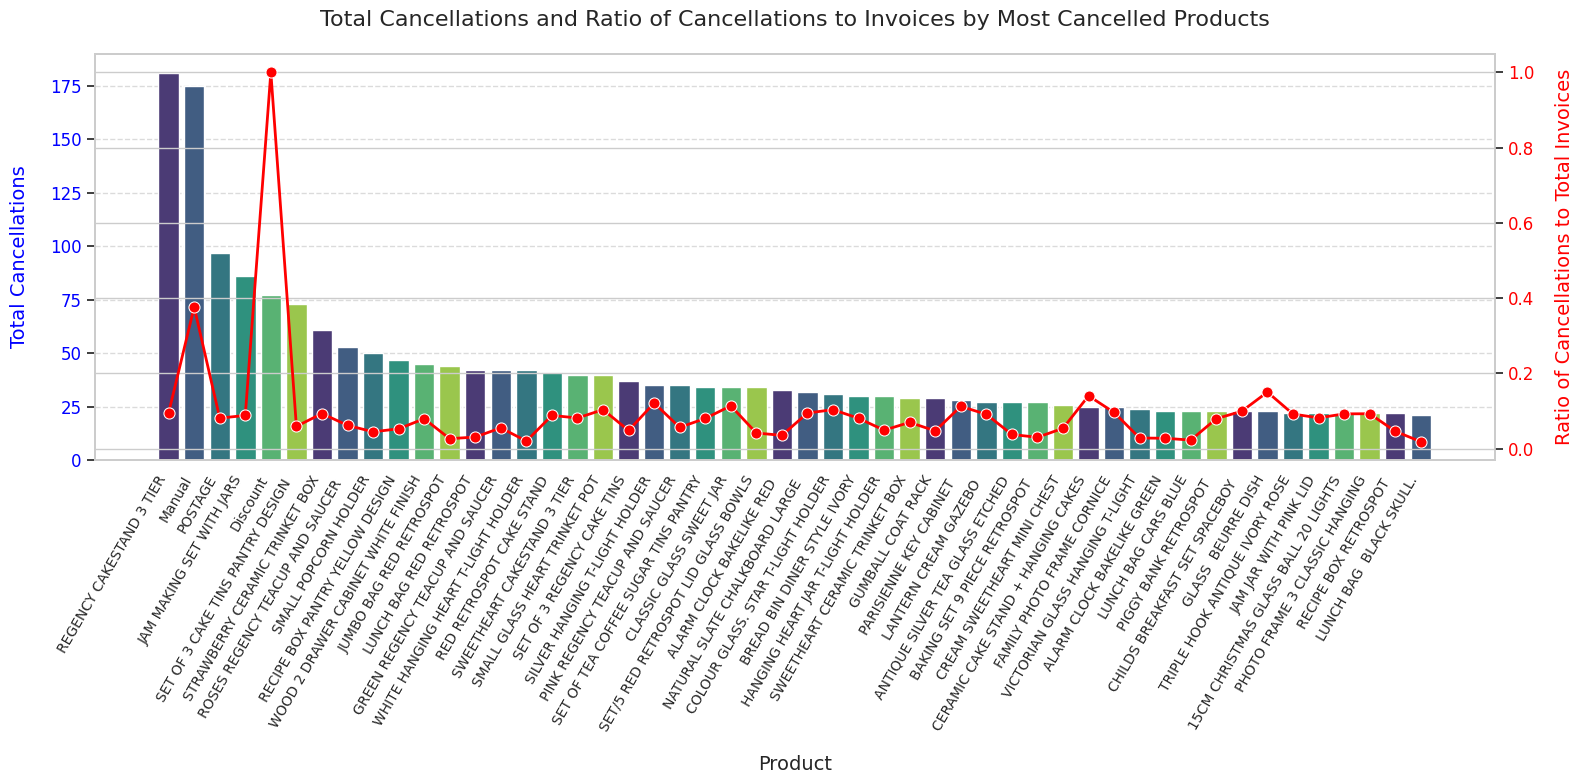

In [43]:
# now to get the rate of cancellations for each stockCode:
pipeline = [
    {
        "$addFields": {
            "is_cancelled": {"$regexMatch": {"input": "$InvoiceNo", "regex": "^C"}}
        }
    },
    {
        "$group": {
            "_id": "$StockCode",
            "description": {"$first": "$Description"},
            "total_invoices": {"$sum": 1},
            "cancelled_count": {
                "$sum": {"$cond": [{"$eq": ["$is_cancelled", True]}, 1, 0]}
            }
        }
    },
    {
        "$addFields": {
            "cancellation_rate": {
                "$cond": [
                    {"$eq": ["$total_invoices", 0]},
                    0,
                    {"$divide": ["$cancelled_count", "$total_invoices"]}
                ]
            }
        }
    },
    {"$sort": {"cancelled_count": -1}}   
]

ratio_cancellations_product = list(invoices.aggregate(pipeline))

plot_data = {
    'Description' : [doc['description'] for doc in ratio_cancellations_product[:50]],
    'Cancellation Rate' : [doc['cancellation_rate'] for doc in ratio_cancellations_product[:50]],
    'Total Cancellations' : [doc['cancelled_count'] for doc in ratio_cancellations_product[:50]]
}
plot_data = pd.DataFrame(plot_data)
plot_data["Description"] = plot_data["Description"].astype(str)
print(plot_data.columns)

sns.set(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(16,8))
palette = sns.color_palette("viridis")
sns.barplot(x="Description", y="Total Cancellations", data = plot_data, palette=palette, ax=ax1)
ax1.set_xlabel("Product", fontsize=14, labelpad=15)
ax1.set_ylabel("Total Cancellations", color="blue", fontsize=14, labelpad=15)
ax1.tick_params(axis="y", labelcolor="blue", labelsize=12)
ax1.tick_params(axis="x", labelsize=10, grid_color="gray")
ax1.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=60, ha="right", fontsize=10)

ax2 = ax1.twinx()
sns.lineplot(x="Description", y="Cancellation Rate", data=plot_data, color="red", marker="o", linewidth=2, markersize=8, ax=ax2)
ax2.set_ylabel("Ratio of Cancellations to Total Invoices", color="red", fontsize=14, labelpad=15)
ax2.tick_params(axis="y", labelcolor="red", labelsize=12)

plt.title("Total Cancellations and Ratio of Cancellations to Invoices by Most Cancelled Products", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

### In an effort to reduce cancellations, incoming ecommerce sellers should prefer to sell outside of software, and computers. Additionally, attempting to reduce returns (which I believe are the discounted invoices) is critical to ensure a boost in profits. Furthermore I find that manuals do not sell well as they are often returned and sellers should aim to 

object


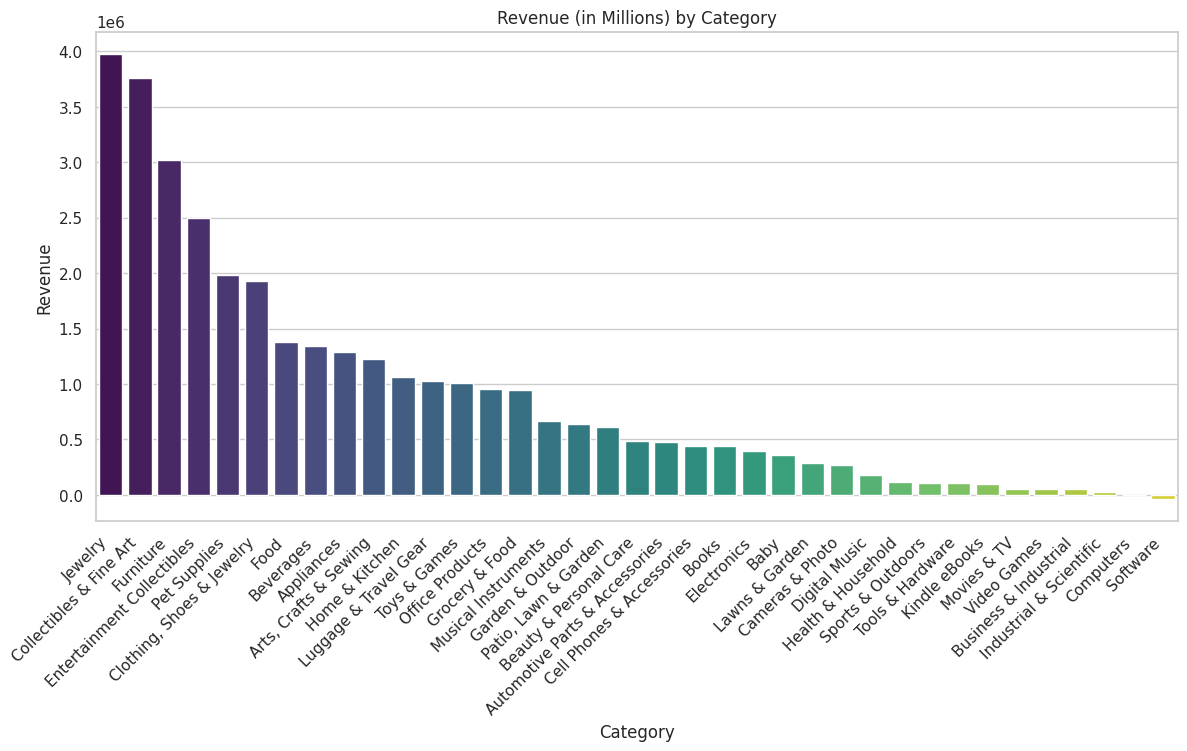

In [44]:
# which categories sell best including cancellations?
pipeline = [
    {
        "$addFields": {
            "revenue": {"$multiply": ["$Quantity", "$UnitPrice"]}
        }
    },
    {"$unwind": "$Categories"},
    {
        "$group": {
            "_id": "$Categories",
            "total_revenue": {"$sum": "$revenue"}
        }
    },
    {"$sort": {"total_revenue": -1}},
]

best_categories = list(invoices.aggregate(pipeline))
# NOTE: invoices have multiple categories, so double counting occurs. Thus summing these does NOT give the total revenue.

plot_data = {
    'Category' : [doc['_id'] for doc in best_categories],
    'Revenue' : [doc['total_revenue'] for doc in best_categories]
}
plot_data = pd.DataFrame(plot_data)

barplot(plot_data, 'Category', 'Revenue', 'Revenue (in Millions) by Category')

object


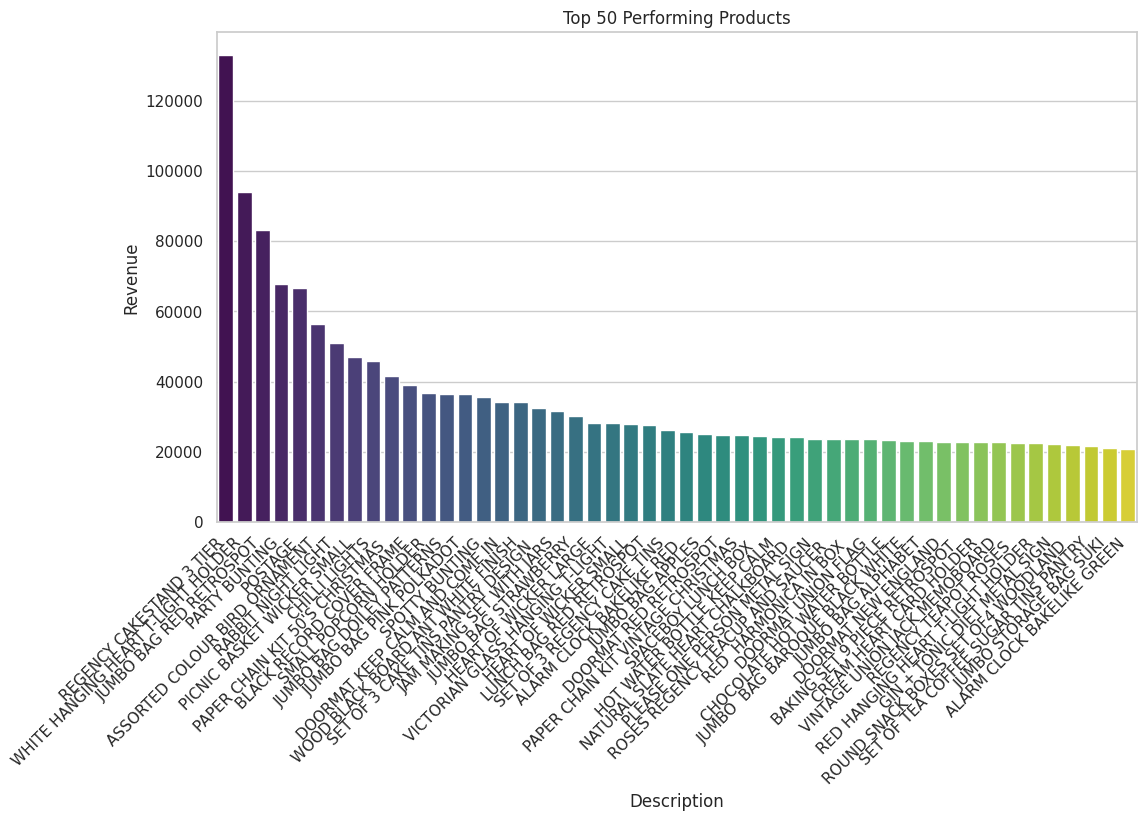

In [45]:
# most profitable products
pipeline = [
    {
        "$addFields": {
            "revenue": {"$multiply": ["$Quantity", "$UnitPrice"]}
        }
    },
    {
        "$group": {
            "_id": "$StockCode",
            "description": {"$first": "$Description"},
            "total_revenue": {"$sum": "$revenue"}
        }
    },
    {"$sort": {"total_revenue": -1}}
]

top_50_products = list(invoices.aggregate(pipeline))

pipeline = [
    {
        "$match" : {"InvoiceNo" : {"$regex" : "^C"}}
    },
    {
        "$group" : {
            "_id" : "$StockCode",
            "Cancellations" : {"$sum" : 1},
            "description" : {"$first" : "$Description"},
            "categories" : {"$addToSet" : "$Categories"}
        }
    },
    {
        "$sort" : {"Cancellations": -1}
    }
]

cancelled_items = list(invoices.aggregate(pipeline))

cancelled_items = set([doc['description'] for doc in cancelled_items])
plot_data = {
    'Description' : [doc['description'] for doc in top_50_products[:50]],
    'Revenue' : [doc['total_revenue'] for doc in top_50_products[:50]]
}

top_products = pd.DataFrame(plot_data)

barplot(top_products, 'Description', 'Revenue', 'Top 50 Performing Products')

     StockCode                       description_x  total_revenue  \
0        22423            REGENCY CAKESTAND 3 TIER      132870.40   
1       85123A  WHITE HANGING HEART T-LIGHT HOLDER       93979.20   
2       85099B             JUMBO BAG RED RETROSPOT       83236.76   
3        47566                       PARTY BUNTING       67687.53   
4         POST                             POSTAGE       66710.24   
...        ...                                 ...            ...   
1915    79323W                 WHITE CHERRY LIGHTS         -54.00   
1916     22769        CHALKBOARD KITCHEN ORGANISER         -87.80   
1917         D                            Discount       -5696.22   
1918      CRUK                     CRUK Commission       -7933.43   
1919         M                              Manual      -58385.46   

      Cancellations                       description_y  
0               181            REGENCY CAKESTAND 3 TIER  
1                42  WHITE HANGING HEART T-LIGHT HOLDER

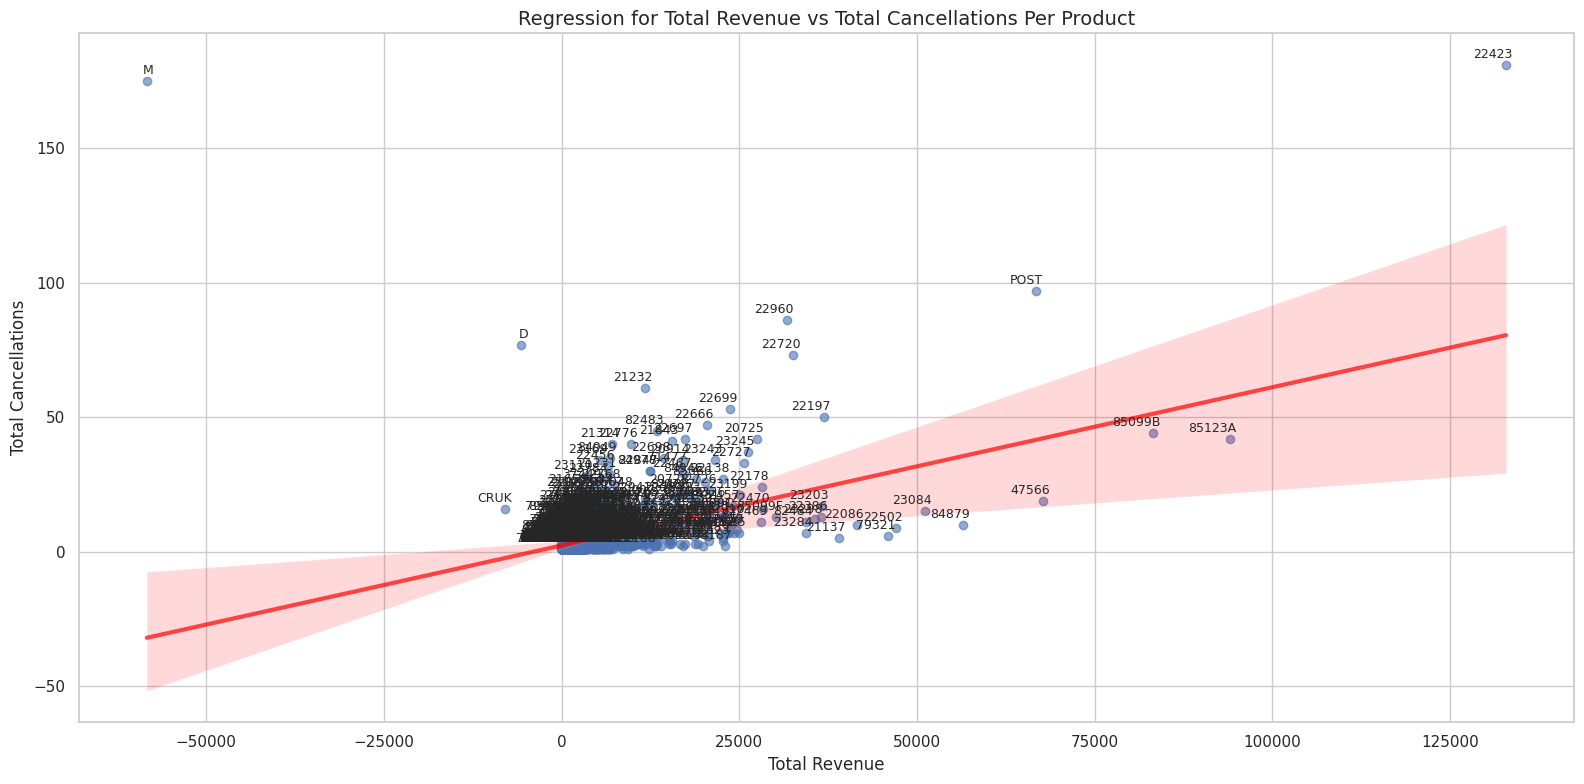

In [46]:
# since there seems to be a strong correlation between the total sales of a product and the number of cancellations
# get total revenue
pipeline = [
    {
        "$addFields": {
            "revenue": {"$multiply": ["$Quantity", "$UnitPrice"]}
        }
    },
    {
        "$group": {
            "_id": "$StockCode",
            "description": {"$first": "$Description"},
            "total_revenue": {"$sum": "$revenue"}
        }
    },
    {"$sort": {"total_revenue": -1}}
]

revenue = list(invoices.aggregate(pipeline))

pipeline = [
    {
        "$match" : {"InvoiceNo" : {"$regex" : "^C"}}
    },
    {
        "$group" : {
            "_id" : "$StockCode",
            "Cancellations" : {"$sum" : 1},
            "description" : {"$first" : "$Description"}
        }
    },
    {
        "$sort" : {"Cancellations": -1}
    }
]

cancelled_items = list(invoices.aggregate(pipeline))

revenue_data = pd.DataFrame(revenue)
cancels_data = pd.DataFrame(cancelled_items)

reg_data = pd.merge(revenue_data, cancels_data, on="_id", how="inner").rename(columns={"_id" : "StockCode"})
print(reg_data)

X = reg_data["total_revenue"].values.reshape(-1,1)
y = reg_data['Cancellations'].values

model = LinearRegression()
model.fit(X,y)
y_pred = model.predict(X)

r2 = r2_score(y, y_pred)

print(f"Regression Coefficients: {model.coef_[0]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")
print(f"R-squared: {r2:.4f}")

plot_data = pd.DataFrame({
    "Total Revenue" : X.flatten(),
    "Total Cancellations" : y
})
plt.figure(figsize=(16,8))
sns.regplot(
    x="Total Revenue",
    y="Total Cancellations",
    data = plot_data, 
    line_kws = {"color": "red", "alpha":0.7, "lw":3},
    scatter_kws={"alpha":0.6},
)

for i, row in reg_data.iterrows():
    plt.annotate(
        row["StockCode"],  
        (row["total_revenue"], row["Cancellations"]),  
        textcoords="offset points", 
        xytext=(5, 5),  
        ha="right", 
        fontsize=9
    )

plt.xlabel("Total Revenue", fontsize=12)
plt.ylabel("Total Cancellations", fontsize=12)
plt.title("Regression for Total Revenue vs Total Cancellations Per Product", fontsize=14)

plt.tight_layout()
plt.show()

# Overall Conclusions - MongoDB

### With MongoDB I focused more on analyzing cancellations and profit through individual products and categories. From the categories we see that the best performing revenue wise are Jewelry, Collectibles and Fine art, and Furniture. Therefore, I believe that companies in these categories who are not already selling online are losing potential profits on the order of millions depending on stock. Successful products such as, 85123A (WHITE HANGING HEART T-LIGHT HOLDER) and 85099B (JUMBO BAG RED RETROSPOT) certainly fall within these categories. Additionally, products such as manuals are not a good sell on internet platforms. They struggle to maintain any positive revenue due alone to cancellations and would be advised to not sell on the internet. This may be a result of the website this data was collected upon, however, without knowing that information it is hard to say.